# Homelessness Impact Analysis
**Data Source:** JABookings CSV logs (Dec 2025 - Jan 2026).

This notebook focuses on individuals whose address is listed as 'HOMELESS' to understand their interaction with the justice system.

**Key Questions:**
1.  **Prevalence:** What % of bookings are homeless?
2.  **Offenses:** What are the most common charges?
3.  **Bonds:** How do bond types/amounts compare to the non-homeless population?

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading & Cleaning
Loading all `JABookings_*.csv` files.

In [2]:
files = sorted(glob.glob("JABookings_*.csv"))
print(f"Found {len(files)} booking files.")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if dfs:
    data = pd.concat(dfs, ignore_index=True)
    
    # Deduplicate
    data = data.drop_duplicates(subset=['SONumber', 'CaseNumber', 'ConfineDate'])
    
    # DateTime conversion
    data['ConfineDate'] = pd.to_datetime(data['ConfineDate'], errors='coerce')
    
    # Clean Bond Amount
    def clean_bond(x):
        if pd.isna(x) or str(x).strip() == '': return 0.0
        try:
            return float(str(x).replace(',', '').replace('$', ''))
        except:
            return 0.0
            
    data['BondAmount_Clean'] = data['BondAmount'].apply(clean_bond)
else:
    data = pd.DataFrame()
    print("No data loaded.")

print(f"Total Records: {len(data)}")

Found 30 booking files.
Total Records: 5824


## 2. Identifying Homeless Individuals
We flag records where `Address1` contains "HOMELESS".

Homeless Bookings: 223 (3.83%)
Non-Homeless Bookings: 5601


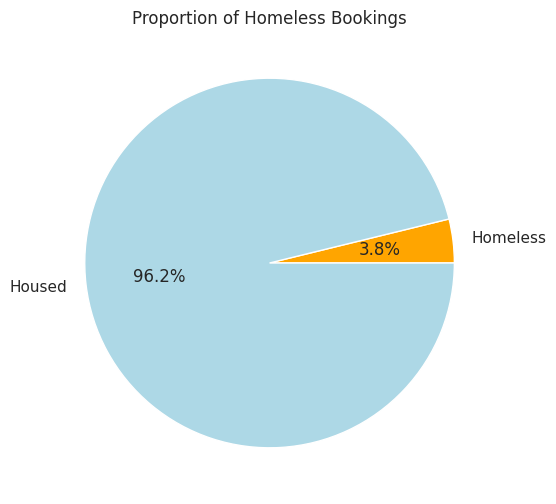

In [3]:
data['IsHomeless'] = data['Address1'].astype(str).str.contains('HOMELESS', case=False, na=False)

homeless_counts = data['IsHomeless'].value_counts()
homeless_pct = (homeless_counts[True] / len(data)) * 100

print(f"Homeless Bookings: {homeless_counts.get(True, 0)} ({homeless_pct:.2f}%)")
print(f"Non-Homeless Bookings: {homeless_counts.get(False, 0)}")

plt.figure(figsize=(6, 6))
plt.pie([homeless_counts.get(True, 0), homeless_counts.get(False, 0)], 
        labels=['Homeless', 'Housed'], autopct='%1.1f%%', colors=['orange', 'lightblue'])
plt.title('Proportion of Homeless Bookings')
plt.show()

## 3. Offense Analysis
Comparing top charges between Homeless and Housed populations.

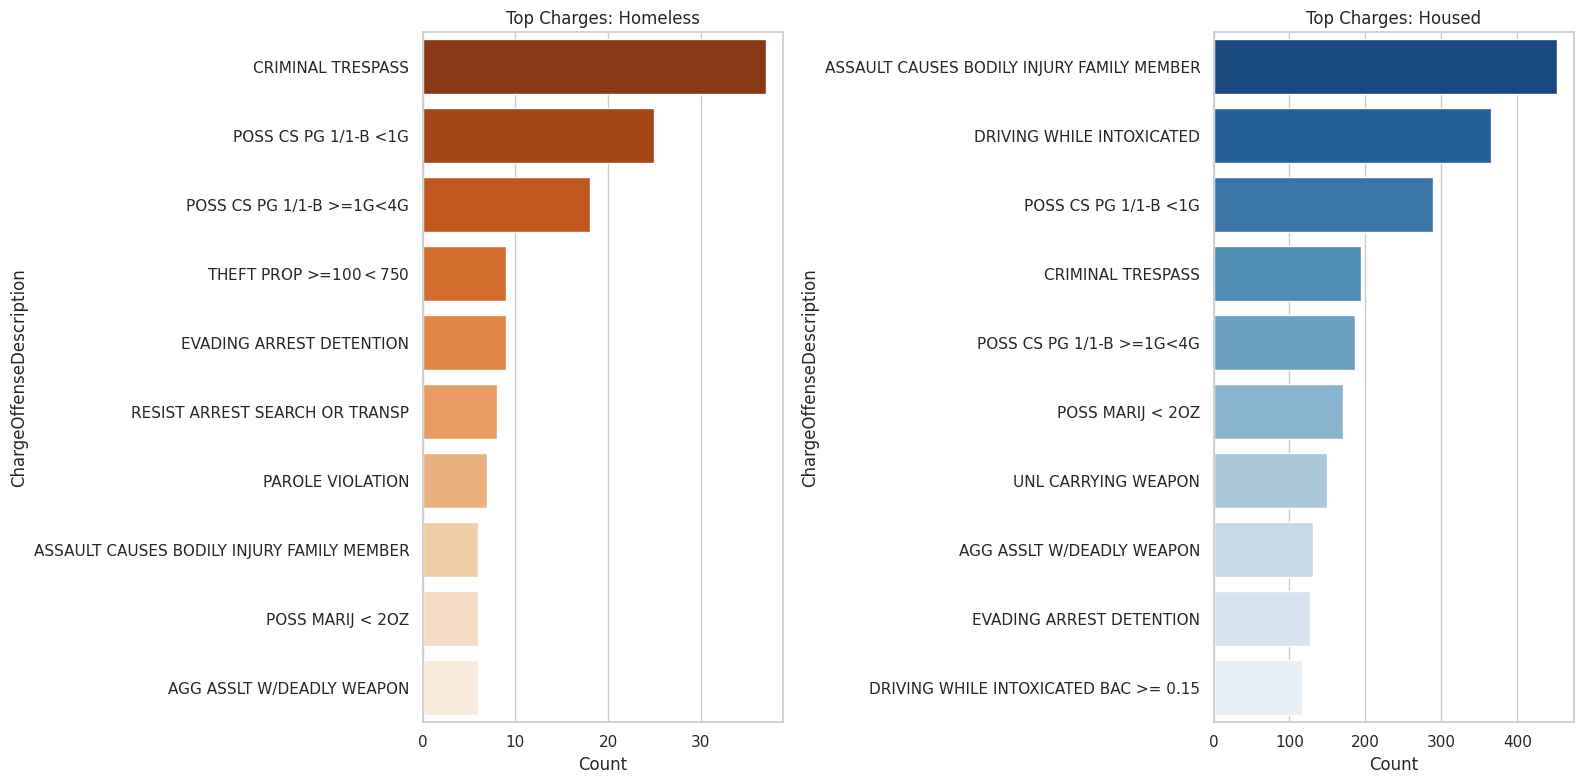

In [4]:
def get_top_offenses(df, n=10):
    return df['ChargeOffenseDescription'].value_counts().head(n)

top_homeless = get_top_offenses(data[data['IsHomeless']])
top_housed = get_top_offenses(data[~data['IsHomeless']])

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(y=top_homeless.index, x=top_homeless.values, ax=axes[0], hue=top_homeless.index, legend=False, palette='Oranges_r')
axes[0].set_title('Top Charges: Homeless')
axes[0].set_xlabel('Count')

sns.barplot(y=top_housed.index, x=top_housed.values, ax=axes[1], hue=top_housed.index, legend=False, palette='Blues_r')
axes[1].set_title('Top Charges: Housed')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

## 4. Bond Analysis
Are homeless individuals facing higher financial barriers relative to their offenses?

Median Bond Amounts:
IsHomeless
False    150.0
True       0.0
Name: BondAmount_Clean, dtype: float64

Bond Type Distribution (%):


BondType,Attorney Bond,Cash Bond,Cash Bond Non-Financial,Cash Non-Profit Bond - TJF,Cash Non-Profit Bond - TOP,Corporate Surety,Licensed Surety,Out of County Bond,Personal Recognizance Bond,Personal Recognizance Bond-Court
IsHomeless,,,,,,,,,,
False,4.517965,0.249022,2.703664,0.035575,0.035575,50.302383,19.708289,0.39132,22.020633,0.035575
True,0.000000,0.000000,1.724138,0.000000,0.000000,25.862069,1.724138,0.00000,70.689655,0.000000


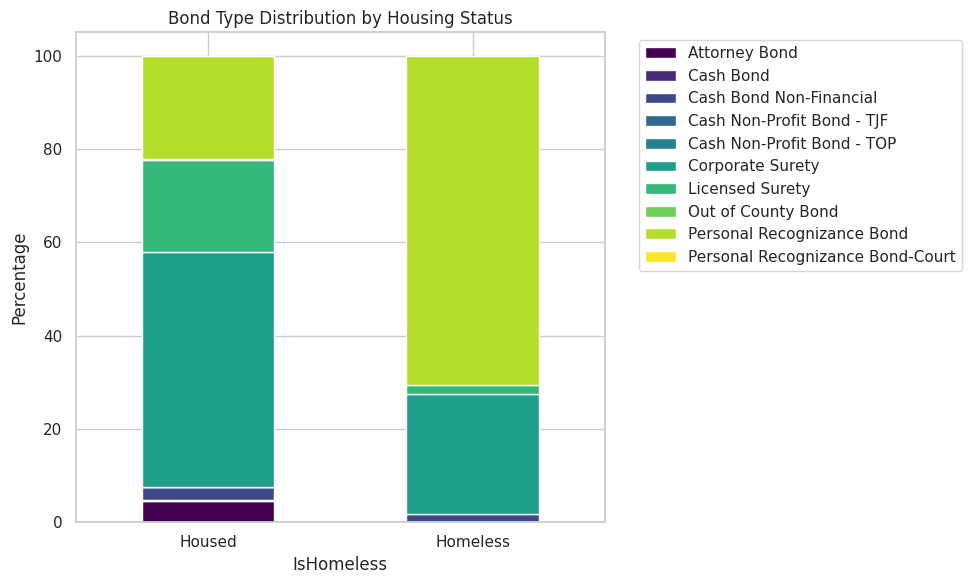

In [5]:
# Median Bond Amount
median_bond = data.groupby('IsHomeless')['BondAmount_Clean'].median()
print("Median Bond Amounts:")
print(median_bond)

# Bond Type Distribution
bond_types = data.groupby(['IsHomeless', 'BondType']).size().unstack(fill_value=0)
# Normalize to show percentage within group
bond_types_pct = bond_types.div(bond_types.sum(axis=1), axis=0) * 100

print()
print("Bond Type Distribution (%):")
display(bond_types_pct)

bond_types_pct.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
plt.title('Bond Type Distribution by Housing Status')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Housed', 'Homeless'], rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Daily Trend
Is the number of homeless arrests increasing?

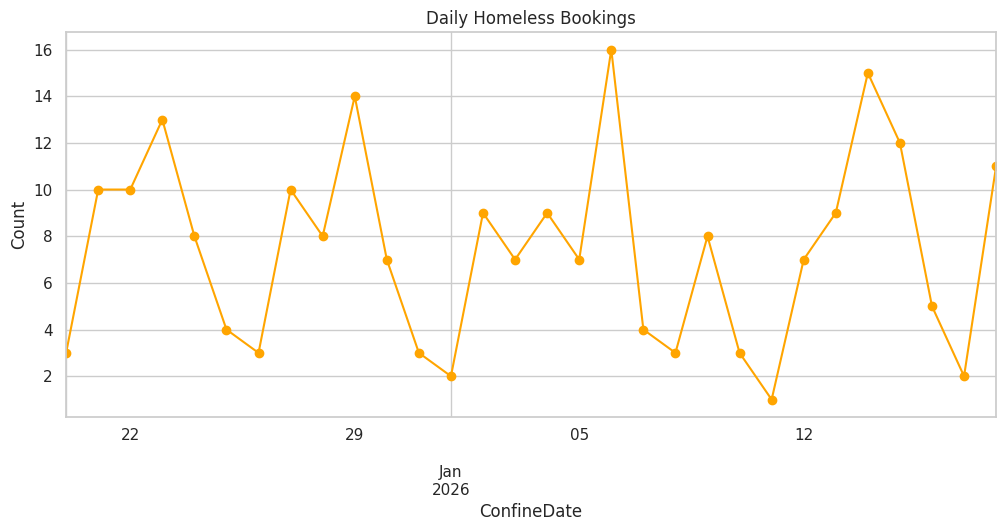

In [6]:
daily_homeless = data[data['IsHomeless']].groupby('ConfineDate').size()

plt.figure(figsize=(12, 5))
daily_homeless.plot(marker='o', color='orange')
plt.title('Daily Homeless Bookings')
plt.ylabel('Count')
plt.show()